In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import seaborn as sns

# Define drift and diffusion

In [3]:
def trayectories(pos_init, time_step, noise, iterations, sets, example, L = 4, delta_u = 5, k = 3, gamma = 1, T=1, kb=1):
###create trayectories using a predefined drift and diffussion
    positions =[pos_init]
    time = 0
    time_list = [time]
    for j in range (0, sets,1):
        pos = pos_init  
        for i in range (1,iterations,1):
            if example == "double_well":
                update =  ((4*delta_u*pos/(L**2) - (4*delta_u*pos**3)/L**4))*time_step + np.sqrt(2*kb*T/gamma)*noise[i]
            if example == "harmonic_oscillator":
                update = ((-k/gamma)*pos)*time_step + np.sqrt(2*kb*T/gamma)*noise[i]
            pos = pos + update
            time = time + time_step
            positions.append(pos)
            time_list.append(time)
    
    return np.asarray(positions), np.asarray(time_list)

def trayectories_2d(pos_init, time_step, noise, iterations):
    pos_x = pos_init[0]
    pos_y = pos_init[1]
    positions_x = [pos_x]
    positions_y = [pos_y]
    time = 0
    time_list = [time]
    noise_x = noise[0]
    noise_y = noise[1]

    for i in range(1, iterations):
        update_x = drift_x(pos_x, pos_y)*time_step + np.sqrt(diff_x(pos_x, pos_y))*noise_x[i]
        update_y = drift_y(pos_x, pos_y)*time_step + np.sqrt(diff_y(pos_x, pos_y))*noise_y[i]
        pos_x = pos_x + update_x
        pos_y = pos_y + update_y
        time = time + time_step
        positions_x.append(pos_x)
        positions_y.append(pos_y)
        time_list.append(time)
    
    return np.asarray(positions_x), np.asarray(positions_y), np.asarray(time_list)



# Plotting functions

In [4]:
def plotting(a, b):
    fig, axis = plt.subplots(1, 1, figsize=(10,10))
    axis.plot(a, b)
    axis.set_xlabel("time")
    axis.set_ylabel("position")
    axis.set_title("Double well potential trayectories")
    return()

def plotting_results(pos, array):
    cont = -1
    x= pos
    val= np.zeros((len(x), len(array)))

    for i in range (0, len(array)):
        cont = cont +1
        if array[i]!= 0:
            for k in range(0, len(x)):
                val[k,i] = array[i]*x[k]**cont
    
    return(val)



# Generate library and expected values

In [5]:
#Generate a library for computing drift and difussion term ( 1, x, x**2, x**3x, ...)
def library2d(results_x,results_y, length):
    library = np.ones((1,len(results_x)))
    index_i =[]
    index_j =[]
    for i in range (0, length):
        for j in range(0,length):
            library_column = (results_x**i)*(results_y**j)
            library_column = library_column.reshape(1, len(results_x))
            library = np.concatenate((library, library_column), axis = 0)
            index_i.append(i)
            index_j.append(j)
    
    index = np.asarray(index_i), np.asarray(index_j)
    return library[1:], index

def library(results, length):
    library = np.ones((1,len(results)))
    for i in range (1, length):
        library_column = results**i
        library_column = library_column.reshape(1, len(results))
        library = np.concatenate((library, library_column), axis = 1)
       
    return library



#Compute expectation value for the drift
def output_vectors_dr(lib, dt):
    output = np.diff(lib)/dt
    return(np.asarray(output))

#Compute expectation value for the diffusion
def output_vectors_di(lib, dt, phi, dri):
    output = np.diff(lib)
    output = np.asarray(output)
    output = output.reshape(len(output))
    output = ((output- np.dot(phi,dri)*dt)**2)/dt
    return(output)

a=np.asarray([1,2,3])
b=np.asarray([3,6,9])
library2d(a,b,3)

(array([[  1.,   1.,   1.],
        [  3.,   6.,   9.],
        [  9.,  36.,  81.],
        [  1.,   2.,   3.],
        [  3.,  12.,  27.],
        [  9.,  72., 243.],
        [  1.,   4.,   9.],
        [  3.,  24.,  81.],
        [  9., 144., 729.]]),
 (array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([0, 1, 2, 0, 1, 2, 0, 1, 2])))

# Inferring the drift and difussion term

In [5]:
def msbl_pythonic(PHI, Y, max_iters):

    #default control parameters
    prune_gama = 1*10**-4 
    epsilon_val = 1*10**-8
    lambda_0 = 1
    Learn_Lambda = 1


    N, M = PHI.shape
    N, L = Y.shape

#generate initial values

    gamma = 0.5*np.ones(M) #generate values of gamma for each conlumn of the library (10)
    keep_list = np.arange(0,M) #create indexes for each column of the library
    m = len(keep_list) #count number of elements in keep_list
    mu = np.zeros((M, L))
    count = 0
    index=[]

    for i in range (0, max_iters):
        if min(gamma) < prune_gama:
            for j in range (0, len(gamma)):
                if gamma[j] > prune_gama:  #take indexes of elements less than 
                    index.append(j)
            gamma = gamma[index]
            PHI = PHI[:, index] #extract related lib elements
            keep_list = keep_list[index] #store indexes 
            m = len(gamma) #compute number of indexes taken
            index=[]

        if count == 1: 
            gamm = gamma
    
        mu_old = mu
        Gamma = np.diag(gamma) #create identity matrix with diagonal equal to gamma elements
        G = np.diag(np.sqrt(gamma))

    

        U, S, V = np.linalg.svd(np.dot(PHI,G), full_matrices = False)


    
        U = U.transpose()
        di = len(S)

        if di > 1:
            diag_S = S
            aa= np.diag(diag_S/(diag_S**2 + lambda_0 + 1e-16 ))

    
        else:
            diag_S = S[0]
            aa= diag_S/(diag_S**2 + lambda_0 + 1e-16 )

   

        Xi = np.dot(np.dot(np.dot(G,np.transpose(V)), aa ), U)
        mu = np.dot(Xi,Y)
    

        #update hyperparameters
        gamma_old = gamma
        mu2_bar = (abs(mu)**2)/L
        mu2_bar = mu2_bar.reshape(1, len(mu2_bar))


        multi = sum(np.multiply(np.transpose(Xi), np.dot(PHI, Gamma)))
    
        Sigma_w_diag = np.real(gamma - multi)
        gamma = Sigma_w_diag + mu2_bar
        gamma = gamma.reshape(len(gamma[0]))

        if Learn_Lambda == 1:
            den = N-m + np.sum(Sigma_w_diag/gamma_old)

            lambda_0 = (np.linalg.norm(Y-np.dot(PHI,mu), ord = "fro")**2/L)/den

        count = count +1

    mu = mu.reshape(len(mu))
    mu_final = np.zeros(M)
    mu_final[keep_list] = mu
    
    return mu_final


# 1) Double Well Potential

In [15]:
np.random.seed(1234)
def potential_double_well(x,delta_u,L):
    """"double well potential"""
    return delta_u*(-1 + (x/L)**2)**2

def force_double_well(x,delta_u, L):
    "double well drift force"
    return 4*delta_u*x/(L**2) - (4*delta_u*x**3)/L**4

#Set initial conditions
number_samples = 5000                               #total number of iterations
time_step = 0.2                                     #time step for euler differentation
L_stable = 0                                         #initial position
L =  5                                             #distance from the center to the minimum
H = 4                                               #height of the maximum
C1 = 4*H/(L**2)                                      #First coefficient of drift
C2 = -4*H/(L**4)                                     #Second coefficient diffusion

#Compute gaussian noise, time interval and trayectories
gaussian_noise = np.random.normal(size = number_samples)*np.sqrt(time_step)
trayectories_dw, time_values_dw = trayectories(L_stable, time_step, gaussian_noise, number_samples, 1, "double_well", L, H)

#generate library of functions for regression
lib_dw = library(trayectories_dw[:-1], 20)                    #Use polynomials up to order 20th for library
lib_dw = lib_dw.T

#generate expected value
Edr_dw = output_vectors_dr(trayectories_dw, time_step)          #Compute expectation value
Edr_dw = Edr_dw.reshape(len(Edr_dw), 1) 

In [130]:
C1, C2

(0.64, -0.0256)

CPU times: user 326 ms, sys: 0 ns, total: 326 ms
Wall time: 351 ms


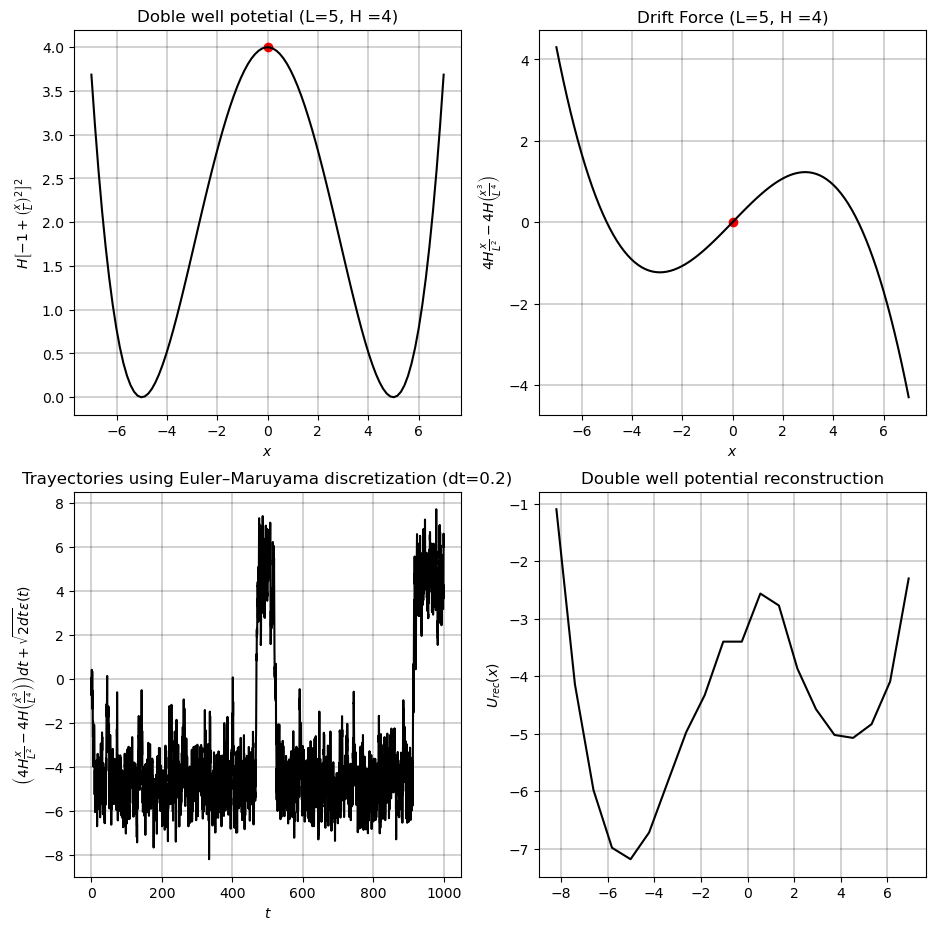

In [18]:
%%time
x_pot = np.linspace(-7,7,100)
#store histogram values
hist_values_dw = plt.hist(trayectories_dw, bins="doane")
hist_x_dw, hist_y_dw = hist_values_dw[0], hist_values_dw[1]
plt.close()

#Plottings
fig, axis = plt.subplots(2,2, figsize=(11,11))
axis[0,0].plot(x_pot, potential_double_well(x_pot, H, L), color = "k") #pOtential has two minimums at L = -4, L = 4 (equilibrium points)
axis[0,0].scatter(L_stable, potential_double_well(L_stable,H, L) , c = "r") 
axis[0,0].set_title("Doble well potetial (L={}, H ={})".format(L,H))
axis[0,0].set_ylabel(r"$H\left [ -1 +\left ( \frac{x}{L}\right)^{2} \right ]^{2}$")
axis[0,0].set_xlabel(r"$x$")
axis[0,0].grid(color='k', linestyle='-', linewidth=0.25)

axis[0,1].plot(x_pot, force_double_well(x_pot, H, L), color = "k") #pOtential has two minimums at L = -4, L = 4 (equilibrium points)
axis[0,1].scatter(L_stable,force_double_well(L_stable,H, L) , c = "r") 
axis[0,1].set_title("Drift Force (L={}, H ={})".format(L,H))
axis[0,1].set_ylabel(r"$4H\frac{x}{L^{2}} - 4H\left ( \frac{x^{3}}{L^{4}} \right )$")
axis[0,1].set_xlabel(r"$x$")
axis[0,1].grid(color='k', linestyle='-', linewidth=0.25)

axis[1,0].plot(time_values_dw, trayectories_dw, color ="k")
axis[1,0].set_title("Trayectories using Euler–Maruyama discretization (dt={})".format(time_step))
axis[1,0].set_ylabel(r"$\left (4H\frac{x}{L^{2}} - 4H\left ( \frac{x^{3}}{L^{4}} \right )  \right )dt + \sqrt{2dt}\varepsilon (t)$")
axis[1,0].set_xlabel(r"$t$")
axis[1,0].grid(color='k', linestyle='-', linewidth=0.25)

axis[1,1].plot(hist_y_dw[:-1],-np.log(hist_x_dw), color = "k")
axis[1,1].set_title("Double well potential reconstruction")
axis[1,1].set_ylabel(r"$U_{rec}(x)$")
axis[1,1].grid(color='k', linestyle='-', linewidth=0.25)

In [8]:
#Compute drift and reject values below the threshold
sol_dr_dw =  msbl_pythonic(lib_dw, Edr_dw, 700)
threshold = 0.02                                                      
sol_dr_dw[abs(sol_dr_dw) < threshold] =0

#Compute difussion using drift and reject values below the threshold
Edi_dw = output_vectors_di(trayectories_dw, time_step, lib_dw, sol_dr_dw)
Edi_dw= Edi_dw.reshape(len(Edi_dw),1)
sol_di_dw=  msbl_pythonic(lib_dw, Edi_dw, 700)
sol_di_dw[abs(sol_di_dw) < threshold] = 0


In [9]:
#Compute L and H from results
C1_obt = sol_dr_dw[1]
C2_obt = sol_dr_dw[3]
D_ob = sol_di_dw[0]

def compute_L(A, B):
    return (-A/B)**(1/2)

def compute_H(A, B):
    return -(1/4)*(A**2/B)

H_obt = round(compute_H(C1_obt, C2_obt),3)
L_obt = round(compute_L(C1_obt, C2_obt),3)

#Compute error
error_L = abs(L-L_obt)/L_obt
error_H = abs(H-H_obt)/H_obt
error_Diff=abs(2-D_ob)/D_ob

print("The error for computing L is: {}".format(error_L*100), "and the accuracy for computing H is: {}".format(error_H*100))

The error for computing L is: 0.47770700636942715 and the accuracy for computing H is: 3.2414126753749475


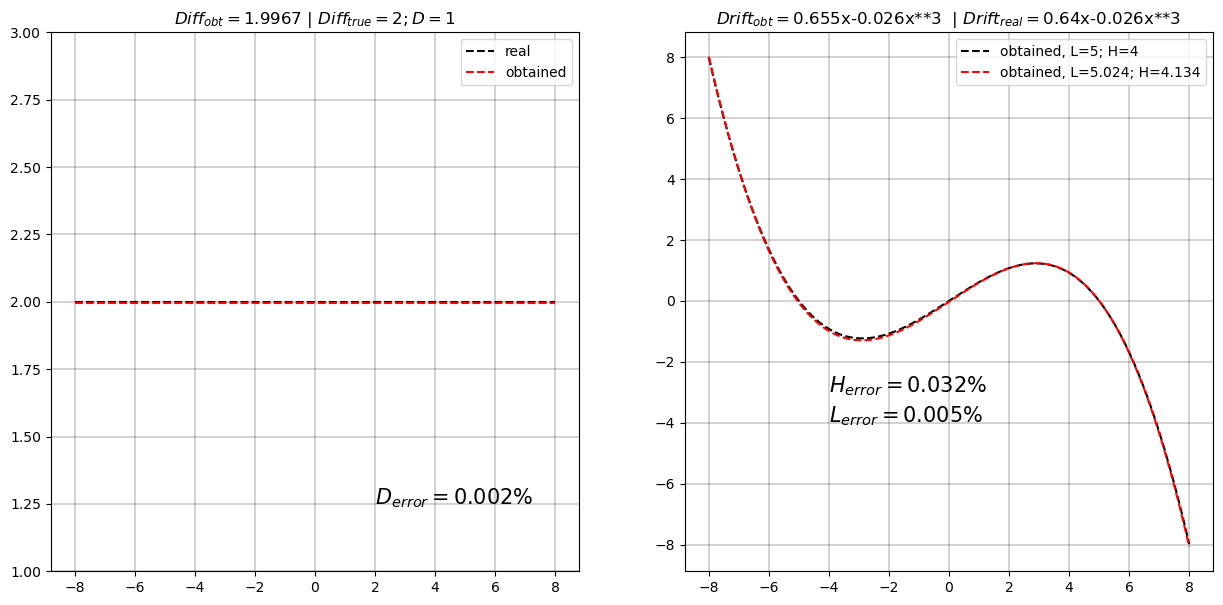

In [11]:
#recreate diffusion and drift equation using obtained coefficients from BISDE
test_pos_dw = np.linspace(-8,8,1000)
difussion_obtained_dw = plotting_results(test_pos_dw, sol_di_dw)
drift_obtained_dw = plotting_results(test_pos_dw, sol_dr_dw)
difussion_obtained_dw = np.sum(difussion_obtained_dw, axis =1 )
drift_obtained_dw= np.sum(drift_obtained_dw, axis =1 )

#set real diffusion and drift equation for later comparison
difussion_real_dw = plotting_results(test_pos_dw, [2,0,0])
drift_real_dw = plotting_results(test_pos_dw,[0,C1,0,C2])
difussion_real_dw = np.sum(difussion_real_dw, axis =1 )
drift_real_dw= np.sum(drift_real_dw, axis =1 )

#plot results
fig, axis = plt.subplots(1, 2, figsize =(15,7))
axis[0].plot(test_pos_dw, difussion_real_dw, label = "real", color ="k", linestyle="dashed")
axis[0].plot(test_pos_dw, difussion_obtained_dw,  label = "obtained", color ="r", linestyle="dashed")
axis[0].set_title(r"$Diff_{obt}=$"+str(round(sol_di_dw[0],4))+" | " + r"$Diff_{true}=$"+"2" +r"$ ; D=1$")
axis[0].set_ylim(1, 3)
axis[0].grid(color='k', linestyle='-', linewidth=0.25)
axis[0].annotate(r"$D_{error}=$" + str(round(error_Diff,3))+"%", xy = (2 , 1.25), size = 15)
axis[0].legend()

axis[1].plot(test_pos_dw, drift_real_dw, label = "obtained, L={}; H={}".format(L, H), color = "k", linestyle="dashed")
axis[1].plot(test_pos_dw, drift_obtained_dw , label = "obtained, L={}; H={}".format(L_obt, H_obt) , color ="r", linestyle="dashed")
axis[1].set_title(r"$Drift_{obt}=$"+str(round(sol_dr_dw[1],3))+"x"+str(round(sol_dr_dw[3],3))+"x**3 " +" | " + 
                  r"$Drift_{real}=$"+str(round(C1,3))+"x"+str(round(C2,3))+"x**3")
axis[1].grid(color='k', linestyle='-', linewidth=0.25)
axis[1].annotate(r"$L_{error}=$" + str(round(error_L,3))+"%", xy = (-4 , -4),size =15)
axis[1].annotate(r"$H_{error}=$" + str(round(error_H,3))+"%", xy = (-4 , -3), size = 15)

axis[1].legend()



# 2. HARMONIC POTENTIAL

In [12]:
# plot functions
def harmonic_potential(x,k):
    return (k*x**2)/2
def harmonic_force(x,k):
    return -k*x

#Set initial conditions
number_samples = 100000                                  #total number of iterations
time_step = 0.04                                         #time step for euler differentation
x_stable = 0                                             #initial position
k = 3                                                    #distance from the center to the minimum
gamma = 1                                                #frition coefficient


#Compute gaussian noise, time interval and trayectories
gaussian_noise = np.random.normal(size = number_samples)*np.sqrt(time_step)
trayectories_ha, time_values_ha = trayectories(x_stable, time_step, gaussian_noise, number_samples, 1, "harmonic_oscillator", k=k, gamma = gamma)

#generate library of functions for regression
lib_ha = library(trayectories_ha[:-1], 10)                    #Use polynomials up to order 20th for library
lib_ha = lib_ha.T

#generate expected value
Edr_ha = output_vectors_dr(trayectories_ha, time_step)          #Compute expectation value
Edr_ha = Edr_ha.reshape(len(Edr_ha), 1) 

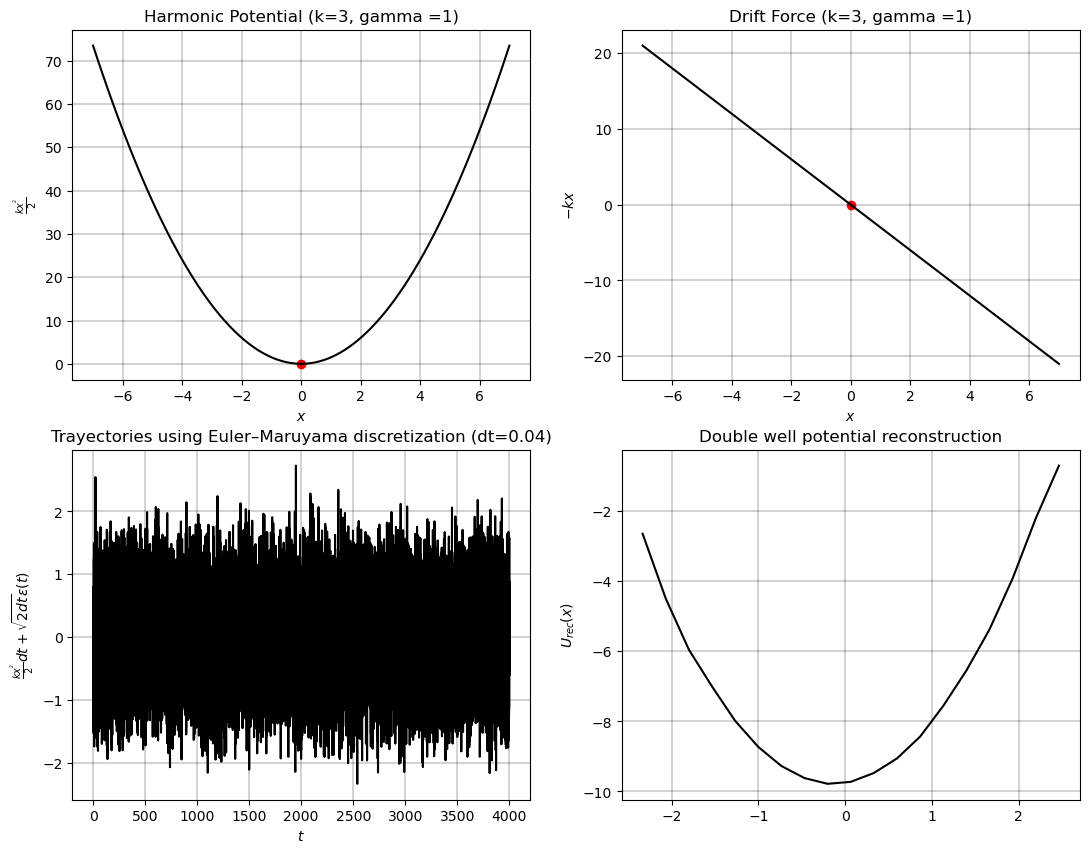

In [13]:
x_pot = np.linspace(-7,7,100)
#store histogram values
hist_values_ha = plt.hist(trayectories_ha, bins="doane")
hist_x_ha, hist_y_ha = hist_values_ha[0], hist_values_ha[1]
plt.close()

#Plottings
fig, axis = plt.subplots(2,2, figsize=(13,10))
axis[0,0].plot(x_pot, harmonic_potential(x_pot,k), color = "k") #pOtential has two minimums at L = -4, L = 4 (equilibrium points)
axis[0,0].scatter(x_stable, harmonic_potential(x_stable,k) , c = "r") 
axis[0,0].set_title("Harmonic Potential (k={}, gamma ={})".format(k,gamma))
axis[0,0].set_ylabel(r"$\frac{kx^{^{2}}}{2}$")
axis[0,0].set_xlabel(r"$x$")
axis[0,0].grid(color='k', linestyle='-', linewidth=0.25)

axis[0,1].plot(x_pot, harmonic_force(x_pot,k), color = "k") #pOtential has two minimums at L = -4, L = 4 (equilibrium points)
axis[0,1].scatter(x_stable, harmonic_force(x_stable,k) , c = "r") 
axis[0,1].set_title("Drift Force (k={}, gamma ={})".format(k,gamma))
axis[0,1].set_ylabel(r"$-kx$")
axis[0,1].set_xlabel(r"$x$")
axis[0,1].grid(color='k', linestyle='-', linewidth=0.25)

axis[1,0].plot(time_values_ha, trayectories_ha, color ="k")
axis[1,0].set_title("Trayectories using Euler–Maruyama discretization (dt={})".format(time_step))
axis[1,0].set_ylabel(r"$\frac{kx^{^{2}}}{2}dt + \sqrt{2dt}\varepsilon (t)$")
axis[1,0].set_xlabel(r"$t$")
axis[1,0].grid(color='k', linestyle='-', linewidth=0.25)

axis[1,1].plot(hist_y_ha[:-1],-np.log(hist_x_ha), color = "k")
axis[1,1].set_title("Double well potential reconstruction")
axis[1,1].set_ylabel(r"$U_{rec}(x)$")
axis[1,1].grid(color='k', linestyle='-', linewidth=0.25)

In [14]:
#Compute drift and reject values below the threshold
sol_dr_ha =  msbl_pythonic(lib_ha, Edr_ha, 700)
threshold = 0.05                                                      
sol_dr_ha[abs(sol_dr_ha) < threshold] =0

#Compute difussion using drift and reject values below the threshold
Edi_ha = output_vectors_di(trayectories_ha, time_step, lib_ha, sol_dr_ha)
Edi_ha= Edi_ha.reshape(len(Edi_ha),1)
sol_di_ha=  msbl_pythonic(lib_ha, Edi_ha, 700)
sol_di_ha[abs(sol_di_ha) < threshold] = 0

In [15]:
#Compute L and H from results
k_obt = sol_dr_ha[1]
D_ob = sol_di_ha[0]

#Compute error
error_k = abs(k-abs(k_obt))/abs(k_obt)
error_Diff=abs(2-D_ob)/D_ob

print("The error for computing k is: {}".format(error_k*100), "and the error for computing Diff is: {}".format(error_Diff*100))

The error for computing k is: 0.09112478740956344 and the error for computing Diff is: 0.3221335849490405


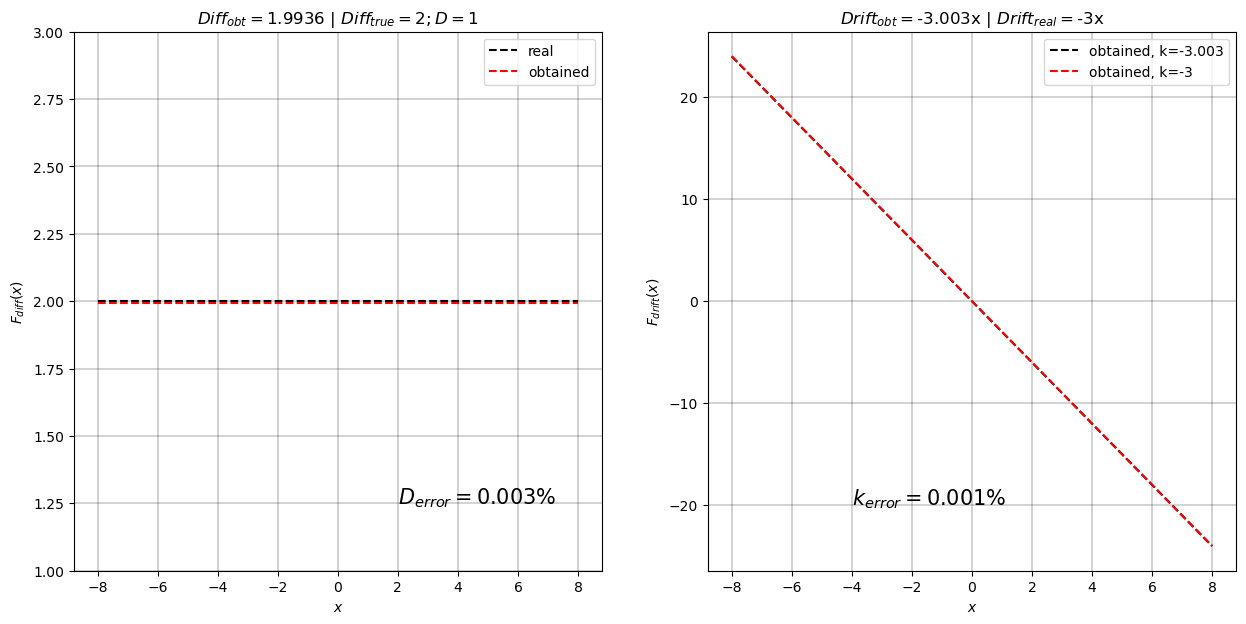

In [16]:
#recreate diffusion and drift equation using obtained coefficients from BISDE
test_pos_ha = np.linspace(-8,8,1000)
difussion_obtained_ha = plotting_results(test_pos_ha, sol_di_ha)
drift_obtained_ha = plotting_results(test_pos_ha, sol_dr_ha)
difussion_obtained_ha = np.sum(difussion_obtained_ha, axis =1 )
drift_obtained_ha= np.sum(drift_obtained_ha, axis =1 )

#set real diffusion and drift equation for later comparison
difussion_real_ha = plotting_results(test_pos_ha, [2,0,0])
drift_real_ha = plotting_results(test_pos_ha,[0,-k/gamma])
difussion_real_ha = np.sum(difussion_real_ha, axis =1 )
drift_real_ha= np.sum(drift_real_ha, axis =1 )

#plot results
fig, axis = plt.subplots(1, 2, figsize =(15,7))
axis[0].plot(test_pos_ha, difussion_real_ha, label = "real", color ="k", linestyle="dashed")
axis[0].plot(test_pos_ha, difussion_obtained_ha,  label = "obtained", color ="r", linestyle="dashed")
axis[0].set_title(r"$Diff_{obt}=$"+str(round(sol_di_ha[0],4))+" | " + r"$Diff_{true}=$"+"2" +r"$ ; D=1$")
axis[0].set_ylim(1, 3)
axis[0].grid(color='k', linestyle='-', linewidth=0.25)
axis[0].annotate(r"$D_{error}=$" + str(round(error_Diff,3))+"%", xy = (2 , 1.25), size = 15)
axis[0].set_xlabel(r"$x$")
axis[0].set_ylabel(r"$F_{diff}(x)$")

axis[0].legend()

axis[1].plot(test_pos_ha, drift_real_ha, label = "obtained, k={}".format(round(k_obt, 3)), color = "k", linestyle="dashed")
axis[1].plot(test_pos_ha, drift_obtained_ha , label = "obtained, k={}".format(-k) , color ="r", linestyle="dashed")
axis[1].set_title(r"$Drift_{obt}=$"+str(round(sol_dr_ha[1],3))+"x" +" | " + 
                  r"$Drift_{real}=$"+str(round(-k,3))+"x")
axis[1].grid(color='k', linestyle='-', linewidth=0.25)
axis[1].annotate(r"$k_{error}=$" + str(round(error_k,3))+"%", xy = (-4 , -20),size =15)
axis[1].set_xlabel(r"$x$")
axis[1].set_ylabel(r"$F_{drift}(x)$")
axis[1].legend()



# 3. 2D Case

In [196]:
def drift_x(x,y):
    """"double well potential"""
    return (x-x**3) -(x*y**2) -y

def drift_y(x,y):
    """"double well potential"""
    return (y-y*(x**2)) - y**3 + x

def diff_x(x,y):
    """"double well potential"""
    return 1 + y**2

def diff_y(x,y):
    """"double well potential"""
    return 1 + x**2

#Set initial conditions
number_samples = 8*10**4                   #total number of iterations
time_step = 0.025                                     #time step for euler differentation
xy_init = [1,1]                                        #initial position


#Compute gaussian noise, time interval and trayectories
gaussian_noise_2d = np.random.normal(size = number_samples)*np.sqrt(time_step), np.random.normal(size = number_samples)*np.sqrt(time_step)
trayectories_x_2d, trayectories_y_2d, time_values_2d = trayectories_2d(xy_init, time_step, gaussian_noise_2d, number_samples)

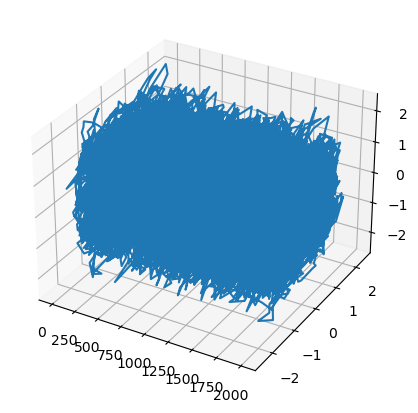

In [197]:
from matplotlib import cm
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')
ax.plot3D(time_values_2d, trayectories_x_2d, trayectories_y_2d)

In [198]:
#generate library of functions for regression
lib_2d, indexes_2d = library2d(trayectories_x_2d[:-1],trayectories_y_2d[:-1], 4)                    
lib_2d = lib_2d.T
label=["1", "y", "y**2", "y**3", "x", "xy", "xy**2", "xy**3", "x**2", "x**2y",
       "x**2y**2", "x**2y**3", "x**3", "x**3y", "x**3y**2", "x**3y**3"]

#generate expectation values
Edr_2dx = output_vectors_dr(trayectories_x_2d, time_step)          
Edr_2dx = Edr_2dx.reshape(len(Edr_2dx), 1) 
Edr_2dy = output_vectors_dr(trayectories_y_2d, time_step)          
Edr_2dy = Edr_2dy.reshape(len(Edr_2dy), 1) 

In [199]:
#Compute drift and reject values below the threshold
sol_dr_2dx =  msbl_pythonic(lib_2d, Edr_2dx, 700)
threshold = 0.1                                                      
sol_dr_2dx[abs(sol_dr_2dx) < threshold] =0

#Compute difussion using drift and reject values below the threshold
Edi_2dx = output_vectors_di(trayectories_x_2d, time_step, lib_2d, sol_dr_2dx)
Edi_2dx= Edi_2dx.reshape(len(Edi_2dx),1)
sol_di_2dx=  msbl_pythonic(lib_2d, Edi_2dx, 1000)
sol_di_2dx[abs(sol_di_2dx) < threshold] = 0

#Compute drift and reject values below the threshold
sol_dr_2dy =  msbl_pythonic(lib_2d, Edr_2dy, 1000)
threshold = 0.1                                                     
sol_dr_2dy[abs(sol_dr_2dy) < threshold] =0

#Compute difussion using drift and reject values below the threshold
Edi_2dy = output_vectors_di(trayectories_y_2d, time_step, lib_2d, sol_dr_2dy)
Edi_2dy= Edi_2dy.reshape(len(Edi_2dy),1)
sol_di_2dy=  msbl_pythonic(lib_2d, Edi_2dy, 1000)
sol_di_2dy[abs(sol_di_2dy) < threshold] = 0

In [201]:
sol_di_2dx

array([0.9927164 , 0.        , 1.02483799, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [202]:
#Compute drift x errors
C1 = sol_dr_2dx[1]
C4 = sol_dr_2dx[4]
C6 = sol_dr_2dx[6]
C12 = sol_dr_2dx[12]
C1_r = -1
C4_r= 1
C6_r = -1
C12_r = -1
#Compute error
error_C1 = abs((C1_r-C1)/C1)
error_C4 = abs((C4_r-C4)/C4)
error_C6 = abs((C6_r-C6)/C6)
error_C12 = abs((C12_r-C12)/C12)

#Compute difF x errors
D0 = sol_di_2dx[0]
D2 = sol_di_2dx[2]
D0_r = 1
D2_r= 1

#Compute error
error_C1 = abs((C1_r-C1)/C1)
error_C4 = abs((C4_r-C4)/C4)
error_C6 = abs((C6_r-C6)/C6)
error_C12 = abs((C12_r-C12)/C12)
error_D0 = abs((D0_r-D0)/D0)
error_D2 = abs((D2_r-D2)/D2)


print("The error for computing the coefficients of the drift x are: C1={}, C4={}, C6={}, C12={}".format(error_C1*100,error_C4*100, error_C6*100, error_C12*100 ))
print("The error for computing the coefficients of the diffusion x are: D0={}, D2={}".format(error_D0*100,error_D2*100))

The error for computing the coefficients of the drift x are: C1=1.2668844517692457, C4=7.136077739362877, C6=6.9636086732205005, C12=2.164636215087662
The error for computing the coefficients of the diffusion x are: D0=0.7337041068282047, D2=2.4236018699627255


In [217]:
sol_dr_2dy

array([ 0.        ,  1.00867922,  0.        , -0.99533302,  1.04419636,
        0.        ,  0.        ,  0.        ,  0.        , -1.20134893,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [216]:
label

['1',
 'y',
 'y**2',
 'y**3',
 'x',
 'xy',
 'xy**2',
 'xy**3',
 'x**2',
 'x**2y',
 'x**2y**2',
 'x**2y**3',
 'x**3',
 'x**3y',
 'x**3y**2',
 'x**3y**3']

In [206]:
#Compute drift x errors
A1 = sol_dr_2dy[1]
A3 = sol_dr_2dy[3]
A4 = sol_dr_2dy[4]
A9 = sol_dr_2dy[9]
A1_r = 1
A3_r= -1
A4_r = 1
A9_r = -1
#Compute error
error_A1 = abs((A1_r-A1)/A1)
error_A3 = abs((A4_r-A3)/A3)
error_A4 = abs((A4_r-A4)/A4)
error_A9 = abs((A9_r-A9)/A9)

#Compute difF x errors
B0 = sol_di_2dy[0]
B8 = sol_di_2dy[8]
B0_r = 1
B8_r= 1

#Compute error
error_A1 = abs((A1_r-A1)/A1)
error_A3 = abs((A3_r-A3)/A3)
error_A4 = abs((A4_r-A4)/A4)
error_A9 = abs((A9_r-A9)/A9)
error_B0 = abs((B0_r-B0)/B0)
error_B8 = abs((B8_r-B8)/B8)


print("The error for computing the coefficients of the drift x are: A1={}, A3={}, A4={}, A9={}".format(error_A1*100,error_A3*100, error_A4*100, error_A9*100 ))
print("The error for computing the coefficients of the diffusion x are: B0={}, B8={}".format(error_B0*100,error_B8*100))

The error for computing the coefficients of the drift x are: A1=0.8604543263203581, A3=0.46888666247337324, A4=4.2325719326064295, A9=16.760236987267454
The error for computing the coefficients of the diffusion x are: B0=0.35773943953054194, B8=1.5129217990840542


In [136]:
def plotting_2d(indexes, array, pos_x, pos_y):
    plot = np.zeros((len(pos_x), len(array)))
    indexes_x = indexes[0]
    indexes_y = indexes[1]
    for i in range(0,len(array)):
        if array[i]!=0:
            for k in range(0,len(pos_x)):
                plot[k,i] = array[i]*(pos_x[k]**indexes_x[i])*(pos_y[k]**indexes_y[i])

    return(plot)


In [210]:
test_pos_2d = np.linspace(-8,8,1000)
difussion_obtained_2dx = plotting_2d(indexes_2d, sol_di_2dx, test_pos_2d, test_pos_2d)
drift_obtained_2dx = plotting_2d(indexes_2d, sol_dr_2dx, test_pos_2d, test_pos_2d)
difussion_obtained_2dx = np.sum(difussion_obtained_2dx, axis =1 )
drift_obtained_2dx= np.sum(drift_obtained_2dx, axis =1 )
drift_real_2dx = test_pos_2d -test_pos_2d**3 - test_pos_2d*test_pos_2d**2 - test_pos_2d
diffusion_real_2dx = 1 + test_pos_2d**2

difussion_obtained_2dy = plotting_2d(indexes_2d, sol_di_2dy, test_pos_2d, test_pos_2d)
drift_obtained_2dy = plotting_2d(indexes_2d, sol_dr_2dy, test_pos_2d, test_pos_2d)
difussion_obtained_2dy = np.sum(difussion_obtained_2dy, axis =1 )
drift_obtained_2dy= np.sum(drift_obtained_2dy, axis =1 )
drift_real_2dy = test_pos_2d -test_pos_2d**3 - test_pos_2d*test_pos_2d**2 + test_pos_2d
diffusion_real_2dy = 1 + test_pos_2d**2

In [ ]:
    return (y-y*(x**2)) - y**3 + x

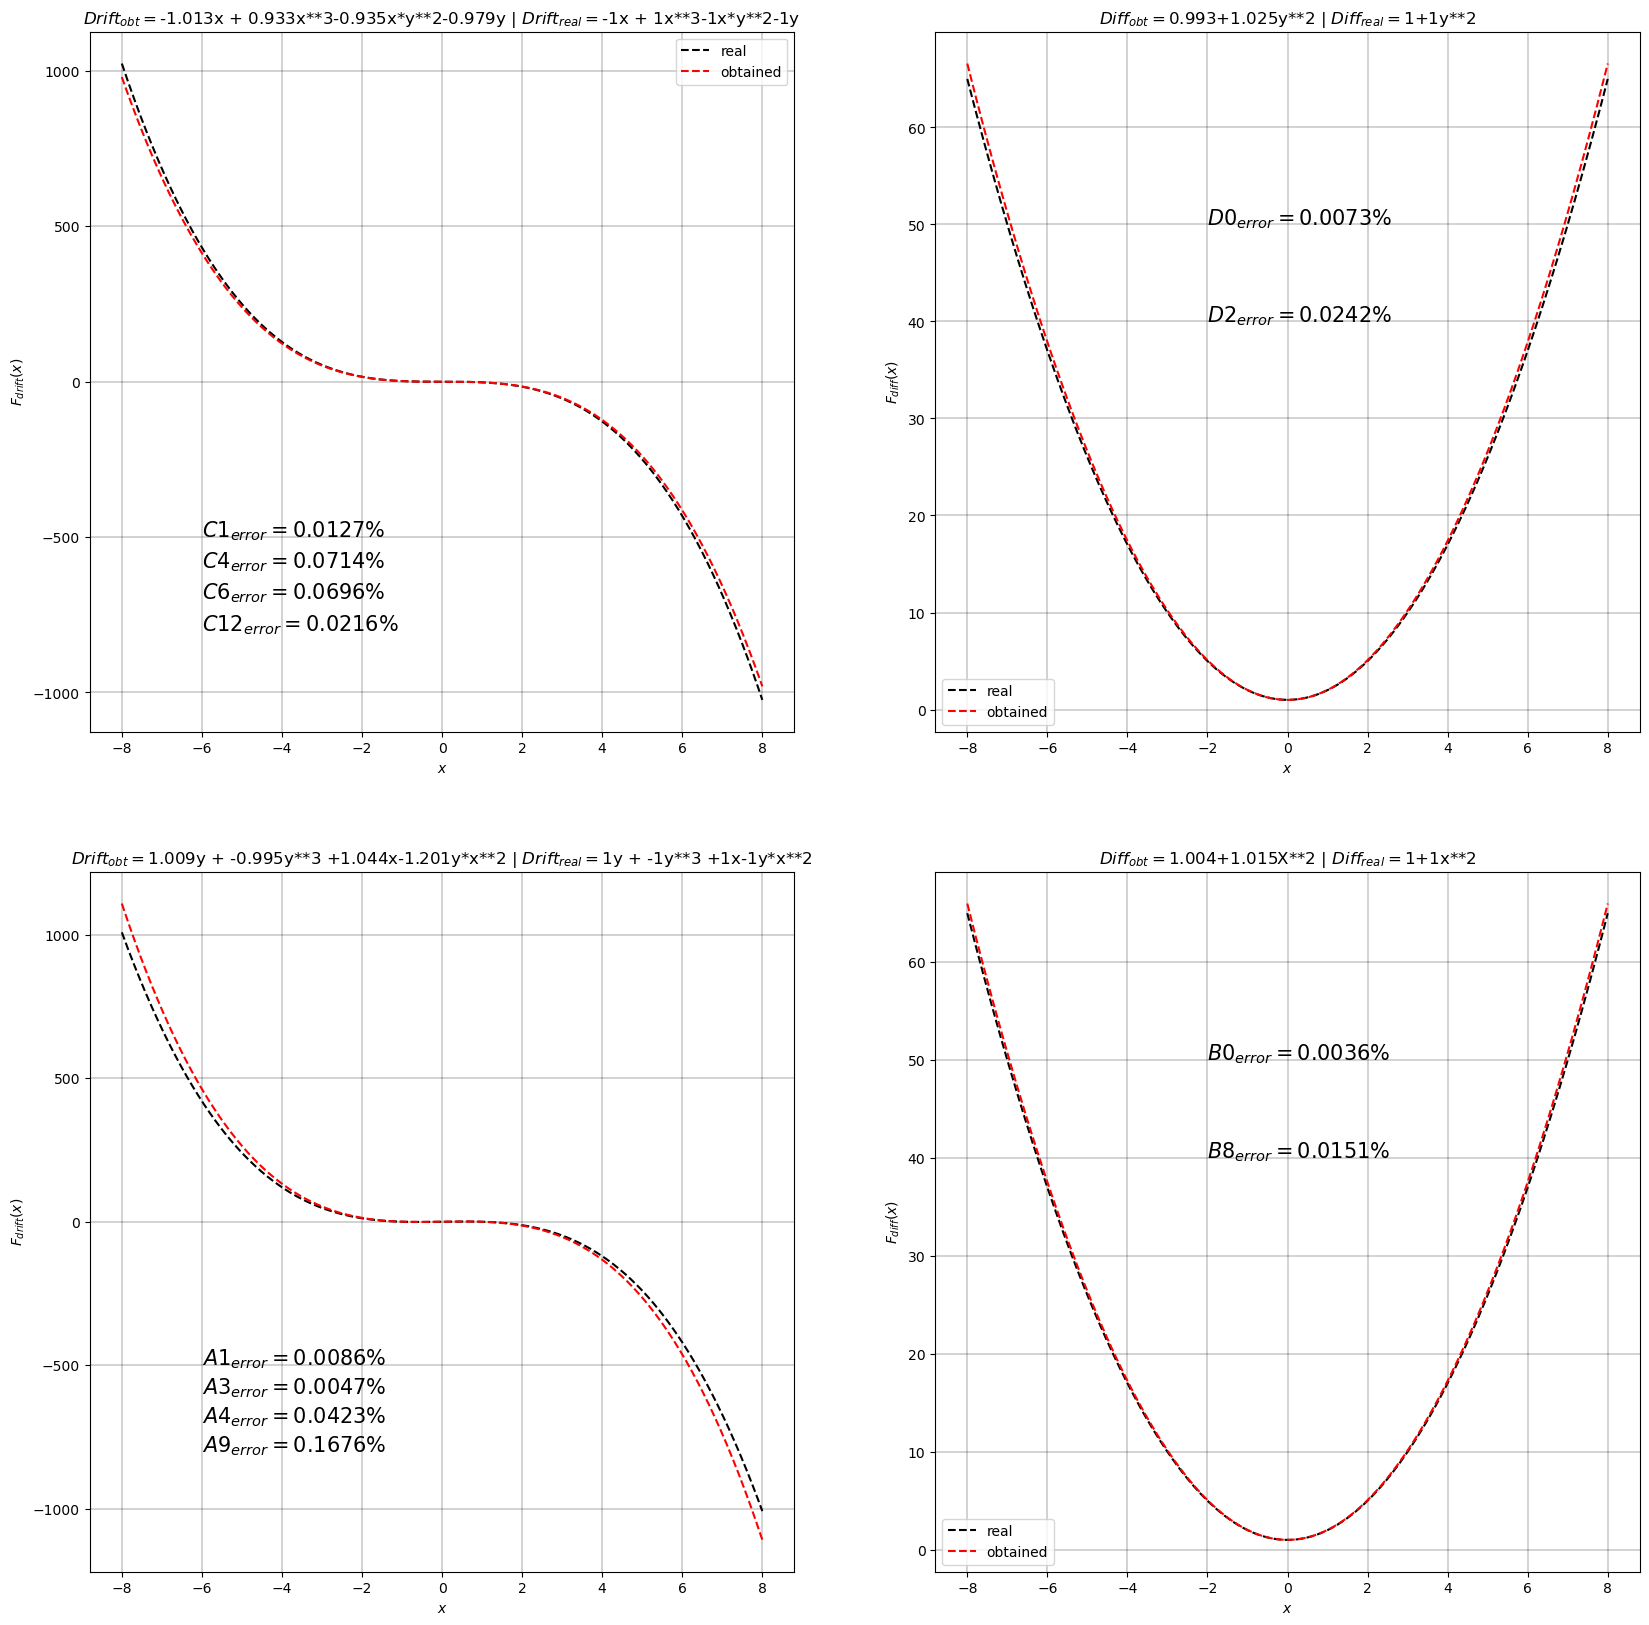

In [220]:
#plot results
fig, axis = plt.subplots(2, 2, figsize =(20,20))
axis[0][0].plot(test_pos_2d, drift_real_2dx, label = "real", color ="k", linestyle="dashed")
axis[0][0].plot(test_pos_2d, drift_obtained_2dx,  label = "obtained", color ="r", linestyle="dashed")
axis[0][0].set_title(r"$Drift_{obt}=$"+str(round(C1,3))+"x + " +str(round(C4,3))+"x**3" + str(round(C6,3))+"x*y**2" + str(round(C12,3))+"y" + " | "
                  r"$Drift_{real}=$"+str(round(C1_r,3))+"x + " +str(round(C4_r,3))+"x**3" + str(round(C6_r,3))+"x*y**2" + str(round(C12_r,3))+"y")
axis[0][0].grid(color='k', linestyle='-', linewidth=0.25)
axis[0][0].annotate(r"$C1_{error}=$" + str(round(error_C1,4))+"%", xy = (-6 , -500),size =15)
axis[0][0].annotate(r"$C4_{error}=$" + str(round(error_C4,4))+"%", xy = (-6 , -600),size =15)
axis[0][0].annotate(r"$C6_{error}=$" + str(round(error_C6,4))+"%", xy = (-6 , -700),size =15)
axis[0][0].annotate(r"$C12_{error}=$" + str(round(error_C12,4))+"%", xy = (-6 , -800),size =15)
axis[0][0].set_xlabel(r"$x$")
axis[0][0].set_ylabel(r"$F_{drift}(x)$")

axis[0][0].legend()

axis[0][1].plot(test_pos_2d, diffusion_real_2dx, label = "real", color = "k", linestyle="dashed")
axis[0][1].plot(test_pos_2d, difussion_obtained_2dx , label = "obtained" , color ="r", linestyle="dashed")
axis[0][1].set_title(r"$Diff_{obt}=$"+str(round(D0,3))+"+"+str(round(D2,3)) +"y**2 | " + 
                  r"$Diff_{real}=$"+str(D0_r)+"+"+str(D2_r) +"y**2")
axis[0][1].grid(color='k', linestyle='-', linewidth=0.25)
axis[0][1].annotate(r"$D0_{error}=$" + str(round(error_D0,4))+"%", xy = (-2 , 50),size =15)
axis[0][1].annotate(r"$D2_{error}=$" + str(round(error_D2,4))+"%", xy = (-2 , 40),size =15)
axis[0][1].set_xlabel(r"$x$")
axis[0][1].set_ylabel(r"$F_{diff}(x)$")
axis[0][1].legend()

axis[1][0].plot(test_pos_2d, drift_real_2dy, label = "real", color ="k", linestyle="dashed")
axis[1][0].plot(test_pos_2d, drift_obtained_2dy,  label = "obtained", color ="r", linestyle="dashed")
axis[1][0].set_title(r"$Drift_{obt}=$"+str(round(A1,3))+"y + " +str(round(A3,3))+"y**3 +" + str(round(A4,3))+"x" + str(round(A9,3))+"y*x**2" + " | "
                  r"$Drift_{real}=$"+str(round(A1_r,3))+"y + " +str(round(A3_r,3))+"y**3 +" + str(round(A4_r,3))+"x" + str(round(A9_r,3))+"y*x**2")
axis[1][0].grid(color='k', linestyle='-', linewidth=0.25)
axis[1][0].annotate(r"$A1_{error}=$" + str(round(error_A1,4))+"%", xy = (-6 , -500),size =15)
axis[1][0].annotate(r"$A3_{error}=$" + str(round(error_A3,4))+"%", xy = (-6 , -600),size =15)
axis[1][0].annotate(r"$A4_{error}=$" + str(round(error_A4,4))+"%", xy = (-6 , -700),size =15)
axis[1][0].annotate(r"$A9_{error}=$" + str(round(error_A9,4))+"%", xy = (-6 , -800),size =15)
axis[1][0].set_xlabel(r"$x$")
axis[1][0].set_ylabel(r"$F_{drift}(x)$")


axis[1][1].plot(test_pos_2d, diffusion_real_2dy, label = "real", color = "k", linestyle="dashed")
axis[1][1].plot(test_pos_2d, difussion_obtained_2dy , label = "obtained" , color ="r", linestyle="dashed")
axis[1][1].set_title(r"$Diff_{obt}=$"+str(round(B0,3))+"+"+str(round(B8,3)) +"X**2 | " + 
                  r"$Diff_{real}=$"+str(B0_r)+"+"+str(B8_r) +"x**2")
axis[1][1].grid(color='k', linestyle='-', linewidth=0.25)
axis[1][1].annotate(r"$B0_{error}=$" + str(round(error_B0,4))+"%", xy = (-2 , 50),size =15)
axis[1][1].annotate(r"$B8_{error}=$" + str(round(error_B8,4))+"%", xy = (-2 , 40),size =15)
axis[1][1].set_xlabel(r"$x$")
axis[1][1].set_ylabel(r"$F_{diff}(x)$")
axis[1][1].legend()

In [112]:
sol_dr_2dy

array([ 0.        ,  0.86416272,  0.        , -0.95795156,  0.97852218,
        0.        ,  0.        ,  0.        ,  0.        , -0.96941724,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [91]:
sol_di_2dx

array([1.00009854, 0.        , 1.00610876, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [89]:
print(sol_dr_2dx)
print(label)

[ 0.         -1.02319073  0.          0.          1.09781369  0.
 -1.00444527  0.          0.          0.          0.          0.
 -1.0354226   0.          0.          0.        ]
['1', 'y', 'y**2', 'y**3', 'x', 'xy', 'xy**2', 'xy**3', 'x**2', 'x**2y', 'x**2y**2', 'x**2y**3', 'x**3', 'x**3y', 'x**3y**2', 'x**3y**3']


# 3. STOCKS PRICE

One year per minute 

In [ ]:
#generate library and expectation values
def manual_library(log_tesla):
    library_manual = [[1 for x in range(0, len(log_tesla[:-1]))],
                  [log_tesla[x]**3 for x in range(0, len(log_tesla[:-1]))],
                  [log_tesla[x]**5 for x in range(0, len(log_tesla[:-1]))],
                  [log_tesla[x]**7 for x in range(0, len(log_tesla[:-1]))],
                  [log_tesla[x]**9 for x in range(0, len(log_tesla[:-1]))],
                  [np.exp(log_tesla[x]) for x in range(0, len(log_tesla[:-1]))],
                  [np.exp(2*log_tesla[x]) for x in range(0, len(log_tesla[:-1]))],
                  [np.exp(3*log_tesla[x]) for x in range(0, len(log_tesla[:-1]))],
                  [np.exp(4*log_tesla[x]) for x in range(0, len(log_tesla[:-1]))],
                  [np.exp(5*log_tesla[x]) for x in range(0, len(log_tesla[:-1]))]]
    library_manual = np.asarray(library_manual)
    library_manual = library_manual.T
    return library_manual

library_manual_minute = manual_library(log_tesla)
library_manual_minute.shape

Y_stocks_tesla = output_vectors_dr(log_tesla, time_step_stocks)
Y_stocks_tesla = Y_stocks_tesla.reshape(len(Y_stocks_tesla), 1) 

In [ ]:
#Compute drift
sol_dr_stock_tesla, list_dr_stock_tesla, new_phi_dr_stock_tesla =  msbl_pythonic(library_manual_minute  , Y_stocks_tesla, 1000)
threshold = 0.05
sol_dr_stock_tesla[abs(sol_dr_stock_tesla) < threshold] =0

In [ ]:
sol_dr_stock_tesla

In [ ]:
#Compute difussion
Y1_stocks_tesla  = output_vectors_di(log_tesla, time_step_stocks,library_manual_minute , sol_dr_stock_tesla)
Y1_stocks_tesla= Y1_stocks_tesla.reshape(len(Y1_stocks_tesla),1)
sol_di_stock_tesla, list_di_stock_tesla, new_phi_di_stock_tesla =  msbl_pythonic(library_manual_minute, Y1_stocks_tesla, 700)
sol_di_stock_tesla[abs(sol_di_stock_tesla) < threshold] =0


In [ ]:
sol_di_stock_tesla

In [ ]:
difussion_obtained_tesla = plotting_results(sol_di_stock_tesla)
drift_obtained_tesla = plotting_results(sol_dr_stock_tesla)

difussion_obtained_tesla = np.sum(difussion_obtained_tesla, axis =1 )
drift_obtained_tesla= np.sum(drift_obtained_tesla, axis =1 )

One year per day

In [ ]:
tesla_daily_year = np.loadtxt("TSLA-1year-daily.csv", delimiter=",", dtype= str)
#remove column names
tesla_daily_year= tesla_daily_year[1:]
tesla_daily_year= tesla_daily_year.T
tesla_daily_year= tesla_daily_year[1:]
tesla_daily_year = tesla_daily_year.astype(float)
time_step_day = 1/251

values_tesla_day = tesla_daily_year[0]
log_tesla_day = np.log(values_tesla_day)
plt.plot(log_tesla_day)

In [ ]:
#Compute library and expectation values
Y_stocks_tesla_day = output_vectors_dr(log_tesla_day, time_step_day)
Y_stocks_tesla_day = Y_stocks_tesla_day.reshape(len(Y_stocks_tesla_day), 1) 
library_day_tesla = manual_library(log_tesla_day)

In [ ]:
#Compute drift
sol_dr_stock_tesla_day, list_dr_stock_tesla_day, new_phi_dr_stock_tesla_day =  msbl_pythonic(library_day_tesla  , Y_stocks_tesla_day, 1000)
threshold = 0.05
sol_dr_stock_tesla_day[abs(sol_dr_stock_tesla_day) < threshold] =0

In [ ]:
sol_dr_stock_tesla_day

# 4) Double well potential

We model the dynamics of the Brownian motion:

$ 0 = -\gamma \dot{x} + f + \sqrt{2K_{b}T}\gamma^{1/2} \varepsilon (t)$

 $\dot{x} =  \frac{f}{\gamma} +\sqrt{\frac{2K_{b}T}{\gamma}} \varepsilon (t)$

In [125]:
from scipy.constants import Boltzmann as kB
### Physical parameters 
R = 1                           # Radius of the Brownian particle [m]
eta = 1                         # Viscosity of the medium [kg m^-1 s^-1]
T = 1                             # Temperature [K]
L = 4                            # Reference distance from middle to one minimum [m]
H = 6                          # Barrier height [Joule]
gamma =  3 * 6 * np.pi * eta * R     # Reference friction coefficient [kg s^-1]
dt = 2e-3
number_samples = 1000


## Function parameters
k0 = 4*H/L**2 
k1 = 4*H/L**4
D = kB * T / gamma
C1 = +k0 / gamma * dt
C2 = -k1 / gamma * dt
C3 = np.sqrt(2 * D * dt)
init = 2e-6
gaussian_noise_new = np.random.normal(size = number_samples)

def trayectories_double_well(C1, C2, C3, noise, init, number_samples):
    Val = []
    X = init
    Val.append(init)
    for i in range (0, number_samples):
        new = C1 * X + C2 * X**3 + C3 * noise[i]
        X = X + new
        Val.append(X)

    return(np.asarray(Val)*1*10**6)

double_trayect = trayectories_double_well(C1,C2,C3, gaussian_noise_new, init, number_samples)

In [119]:
print(C1,C2, C3)

0.0014649140868325484 -366228521.70813715 5.412788720858312e-08


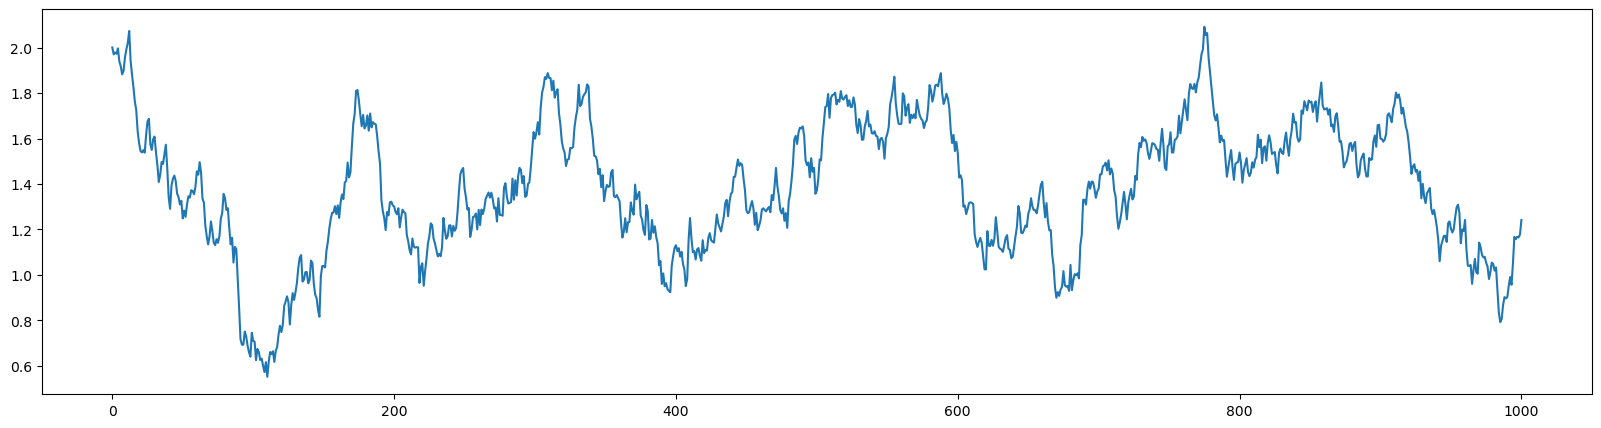

In [115]:
fig, axis = plt.subplots(1, 1, figsize = (20,5))
axis.plot(double_trayect)

In [122]:
#Generate library and expectated value
#generate library
lib_0_force = library(double_trayect[:-1], 20)
lib_0_force = np.transpose(lib_0_force)
#generate expected value
Y_force = output_vectors_dr(double_trayect, dt)
Y_force = Y_force.reshape(len(Y_force), 1) 

In [123]:
#Compute drift
sol_dr_force =  msbl_pythonic(lib_0_force, Y_force, 700)
threshold = 0.05
#sol_dr_force[abs(sol_dr_force) < threshold] =0

ValueError: shapes (1,20000) and (1000,1) not aligned: 20000 (dim 1) != 1000 (dim 0)

In [118]:
sol_dr_force

NameError: name 'sol_dr_force' is not defined